# Viral Tweet Predictor

## Load Library and Scraped Twitter Datasets

Tweets scraped from Fox, CNN, and BBC news stations twitter accounts

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression

import datetime
import time
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import RobustScaler
from matplotlib import pyplot as plt

def clean(txt):
    txt = re.sub(r"https?.*", "", txt)
    txt = re.sub(r"^[A-Z ]*:", "", txt)
    txt = re.sub(r"[^A-Za-z]+", " ", txt)
    return txt.strip()

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rudger_dame1/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
cnn = pd.read_csv("CNN.csv", sep='\t')
cnn["cat"] = 1
fox = pd.read_csv("FOX.csv", sep='\t')
fox["cat"] = 0
bbc = pd.read_csv("BBC.csv", sep='\t')
bbc["cat"] = 2

data = pd.concat([cnn, fox, bbc])
data2 = data.sample(frac=1)
data = data2[:len(data2)//10]
seconds_in_day = 24*60*60
data.head(2)

/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_48206/643705996.py:1: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  cnn = pd.read_csv("CNN.csv", sep='\t')
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_48206/643705996.py:3: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  fox = pd.read_csv("FOX.csv", sep='\t')
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_48206/643705996.py:5: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  bbc = pd.read_csv("BBC.csv", sep='\t')


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,cat
168783,939314226539257861,939314226539257861,2017-12-08 19:02:17 Mountain Standard Time,2017-12-08,19:02:17,-600,759251,cnn,CNN,NaN,"General Electric is cutting 12,000 jobs as its new CEO tries to turn the troubled company around https://t.co/AAbRruWqlH https://t.co/QfhGqwiLm5",en,[],['http://cnn.it/2AHhtW9'],['https://pbs.twimg.com/media/DQkdTzxVwAAzUGA.jpg'],61,132,131,[],[],https://twitter.com/CNN/status/939314226539257861,False,NaN,1,https://pbs.twimg.com/media/DQkdTzxVwAAzUGA.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,1
231799,184437722,184437722,2007-08-03 06:22:07 Mountain Daylight Time,2007-08-03,06:22:07,-600,742143,bbcworld,BBC News (World),NaN,At least 50 people reportedly died after a boat capsized in rough seas off the Sierra Leone coast. http://tinyurl.com/3cdtjq,en,[],[],[],0,0,0,[],[],https://twitter.com/BBCWorld/status/184437722,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2


# Clean Data and Create New Features
Added Features:
- time of tweet (ex. year, day, hour, and sec)
- length of tweet
- number of words
- number of capitalized words
- ratio of capitalized words to number of words
- sentiment analysis
- number of hashtags
- if the tweet had a video or thumbnail

In [4]:
timestamps = data["time"].fillna("23:59:59").values
datestamps = data["date"].replace(r"http:.*", "2020-01-01", regex=True).values

data.head(2)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,cat
168783,939314226539257861,939314226539257861,2017-12-08 19:02:17 Mountain Standard Time,2017-12-08,19:02:17,-600,759251,cnn,CNN,NaN,"General Electric is cutting 12,000 jobs as its new CEO tries to turn the troubled company around https://t.co/AAbRruWqlH https://t.co/QfhGqwiLm5",en,[],['http://cnn.it/2AHhtW9'],['https://pbs.twimg.com/media/DQkdTzxVwAAzUGA.jpg'],61,132,131,[],[],https://twitter.com/CNN/status/939314226539257861,False,NaN,1,https://pbs.twimg.com/media/DQkdTzxVwAAzUGA.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,1
231799,184437722,184437722,2007-08-03 06:22:07 Mountain Daylight Time,2007-08-03,06:22:07,-600,742143,bbcworld,BBC News (World),NaN,At least 50 people reportedly died after a boat capsized in rough seas off the Sierra Leone coast. http://tinyurl.com/3cdtjq,en,[],[],[],0,0,0,[],[],https://twitter.com/BBCWorld/status/184437722,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2


In [5]:
data["day_frac"] = [(60*60*int(i.split(":")[0]) + 60*int(i.split(":")[1]) + int(i.split(":")[2]))/seconds_in_day for i in timestamps]
data["sin_day"] = [np.sin(i * 2*np.pi) for i in data["day_frac"].values]
data["cos_day"] = [np.cos(i * 2*np.pi) for i in data["day_frac"].values]
data["seconds"] = [int(i.split(":")[2])/60 for i in timestamps]
data["minutes"] = [int(i.split(":")[1])/60 for i in timestamps]
data["hours"] = [int(i.split(":")[0])/24 for i in timestamps]
data["year"] = [int(i.split("-")[0]) for i in datestamps]
data["month"] = [int(i.split("-")[1]) for i in datestamps]
data["day"] = [int(i.split("-")[2]) for i in datestamps]
data["unix_time"] = [time.mktime(datetime.datetime(i[2], i[1], i[0]).timetuple())/1000000000 for i in zip(data.day.values, data.month.values, data.year.values)]
data["cleaned_tweet"] = [clean(txt) for txt in data.tweet.fillna("").values]
data["length"] = [len(i) for i in data["cleaned_tweet"].values]
data["num_words"] = [len(i.split(" ")) for i in data.cleaned_tweet.values]
data["num_caps"] = [len(i) for i in data["cleaned_tweet"].replace(r"[^A-Z]","", regex=True)]
data["cap_word_frac"] = (data["num_caps"] / data["num_words"]).replace(np.inf,-1).replace(np.nan, -2)
data["num_hashtag"] = [len(i.split(",")) if i != '[]' else 0 for i in data['hashtags']]
data["thumbn"] = ~data["thumbnail"].isna()
data["thumbn"] = data["thumbn"].astype(int)
data.head(3)


/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_48206/3680701753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day_frac"] = [(60*60*int(i.split(":")[0]) + 60*int(i.split(":")[1]) + int(i.split(":")[2]))/seconds_in_day for i in timestamps]
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_48206/3680701753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["sin_day"] = [np.sin(i * 2*np.pi) for i in data["day_frac"].values]
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,cat,day_frac,sin_day,cos_day,seconds,minutes,hours,year,month,day,unix_time,cleaned_tweet,length,num_words,num_caps,cap_word_frac,num_hashtag,thumbn
168783,939314226539257861,939314226539257861,2017-12-08 19:02:17 Mountain Standard Time,2017-12-08,19:02:17,-600,759251,cnn,CNN,NaN,"General Electric is cutting 12,000 jobs as its new CEO tries to turn the troubled company around https://t.co/AAbRruWqlH https://t.co/QfhGqwiLm5",en,[],['http://cnn.it/2AHhtW9'],['https://pbs.twimg.com/media/DQkdTzxVwAAzUGA.jpg'],61,132,131,[],[],https://twitter.com/CNN/status/939314226539257861,False,NaN,1,https://pbs.twimg.com/media/DQkdTzxVwAAzUGA.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,1,0.793252,-0.963299,0.268429,0.283333,0.033333,0.791667,2017,12,8,1.512713,General Electric is cutting jobs as its new CEO tries to turn the troubled company around,89,16,5,0.312500,0,1
231799,184437722,184437722,2007-08-03 06:22:07 Mountain Daylight Time,2007-08-03,06:22:07,-600,742143,bbcworld,BBC News (World),NaN,At least 50 people reportedly died after a boat capsized in rough seas off the Sierra Leone coast. http://tinyurl.com/3cdtjq,en,[],[],[],0,0,0,[],[],https://twitter.com/BBCWorld/status/184437722,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2,0.265359,0.995347,-0.096352,0.116667,0.366667,0.250000,2007,8,3,1.186117,At least people reportedly died after a boat capsized in rough seas off the Sierra Leone coast,94,17,3,0.176471,0,0
69696,1181707628654804994,1181707628654804994,2019-10-08 17:07:08 Mountain Daylight Time,2019-10-08,17:07:08,-600,759251,cnn,CNN,NaN,"5 native, business &amp; environmental organizations sued the EPA over a proposed controversial Alaska gold and copper mine that the Trump administration has backed after it reversed an Obama-era decision that stopped the project due to environmental concerns https://t.co/UilJ7ywTUm",en,[],['https://cnn.it/2OxBIhG'],[],14,68,201,[],[],https://twitter.com/CNN/status/1181707628654804994,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,1,0.713287,-0.973512,-0.228634,0.133333,0.116667,0.708333,2019,10,8,1.570511,native business amp environmental organizations sued the EPA over a proposed controversial Alaska gold and copper mine that the Trump administration has backed after it reversed an Obama era decision that stopped the project due to environmental concerns,254,38,6,0.157895,0,0


### Sentiment analysis on tweeted text

In [6]:
sia = SentimentIntensityAnalyzer()
sentiments = [sia.polarity_scores(twt) for twt in tqdm(data.cleaned_tweet.values)]
data["neu"] = [d["neu"] for d in sentiments]
data["neg"] = [d["neg"] for d in sentiments]
data["pos"] = [d["pos"] for d in sentiments]
data["com"] = [d["compound"] for d in sentiments]

100%|███████████████████████████████████| 92288/92288 [00:15<00:00, 5787.03it/s]
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_48206/3868843999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["neu"] = [d["neu"] for d in sentiments]
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_48206/3868843999.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["neg"] = [d["neg"] for d in sentiments]
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_48206/3868843999.py:5: Set

## Quantify a Viral Tweet 

To quantify how viral a tweet is, we took the natural log of the number of tweets. We expect the viral nature of a tweet to 
increase in popularity at an exponential scale rather than at a linear rate.

In [7]:
# Tke the natural log of likes and make zero likes equal to -1
data["viral"] = [np.log(i) if i !=0 else -1 for i in data['likes_count'].values]


/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_48206/3053881459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["viral"] = [np.log(i) if i !=0 else -1 for i in data['likes_count'].values]


In [8]:
columns1 = ["day_frac","neu", "neg", "pos", "com", "sin_day","cos_day","seconds","minutes","hours","month","day","cleaned_tweet", "length", "num_words", "num_caps", "cap_word_frac","num_hashtag","cat","thumbn"]
columns2 = ["day_frac","neu", "neg", "pos", "com", "sin_day","cos_day","seconds","minutes","hours","month","day","cleaned_tweet", "length", "num_words", "num_caps", "cap_word_frac","num_hashtag","cat","thumbn","likes_count","retweets_count","replies_count"]

data_short = data[columns1]
data_corr = data[columns2]


## Count Amount of Common Words

In [9]:
vectorizer = CountVectorizer(stop_words="english", max_df=0.1, max_features=50)
vectorizer.fit(data_short["cleaned_tweet"])
temp_data = vectorizer.transform(data_short["cleaned_tweet"])

In [10]:
df = pd.DataFrame(data=temp_data.toarray(),columns=[f"{i}_vocab" for i in vectorizer.get_feature_names()])
df.describe()


/Users/rudger_dame1/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,according_vocab,american_vocab,amp_vocab,attack_vocab,china_vocab,city_vocab,cnn_vocab,coronavirus_vocab,country_vocab,court_vocab,day_vocab,death_vocab,don_vocab,election_vocab,going_vocab,government_vocab,home_vocab,house_vocab,just_vocab,killed_vocab,like_vocab,man_vocab,new_vocab,news_vocab,north_vocab,obama_vocab,officials_vocab,old_vocab,people_vocab,police_vocab,potus_vocab,president_vocab,realdonaldtrump_vocab,report_vocab,russia_vocab,said_vocab,say_vocab,says_vocab,school_vocab,south_vocab,state_vocab,think_vocab,time_vocab,trump_vocab,week_vocab,white_vocab,woman_vocab,world_vocab,year_vocab,years_vocab
count,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000
mean,0.012851,0.014726,0.017001,0.012038,0.013555,0.011973,0.014877,0.014682,0.014281,0.014336,0.016351,0.013512,0.011724,0.013469,0.013794,0.014184,0.011800,0.024283,0.014888,0.017640,0.012353,0.023112,0.056378,0.015430,0.015592,0.023730,0.012439,0.015181,0.038315,0.031217,0.019363,0.065946,0.018670,0.017640,0.011616,0.017370,0.026927,0.059184,0.012342,0.011876,0.021921,0.012103,0.016438,0.075178,0.011681,0.015723,0.013566,0.023004,0.030502,0.018009
std,0.113208,0.127021,0.143195,0.111320,0.122374,0.113639,0.125889,0.123830,0.122159,0.122992,0.131024,0.118511,0.115133,0.119698,0.127381,0.121325,0.112121,0.162821,0.124460,0.132952,0.114311,0.155157,0.241618,0.128507,0.127258,0.156282,0.112003,0.127393,0.200082,0.183250,0.138896,0.267398,0.135357,0.136014,0.111898,0.135929,0.163998,0.240248,0.122148,0.110212,0.155400,0.117562,0.131509,0.278119,0.111017,0.129186,0.119913,0.154544,0.180992,0.136204
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [11]:
new_data = pd.concat([df, data_short.reset_index().drop("index", axis=1)], axis=1)
new_data.head(2)

,according_vocab,american_vocab,amp_vocab,attack_vocab,china_vocab,city_vocab,cnn_vocab,coronavirus_vocab,country_vocab,court_vocab,day_vocab,death_vocab,don_vocab,election_vocab,going_vocab,government_vocab,home_vocab,house_vocab,just_vocab,killed_vocab,like_vocab,man_vocab,new_vocab,news_vocab,north_vocab,obama_vocab,officials_vocab,old_vocab,people_vocab,police_vocab,potus_vocab,president_vocab,realdonaldtrump_vocab,report_vocab,russia_vocab,said_vocab,say_vocab,says_vocab,school_vocab,south_vocab,state_vocab,think_vocab,time_vocab,trump_vocab,week_vocab,white_vocab,woman_vocab,world_vocab,year_vocab,years_vocab,day_frac,neu,neg,pos,com,sin_day,cos_day,seconds,minutes,hours,month,day,cleaned_tweet,length,num_words,num_caps,cap_word_frac,num_hashtag,cat,thumbn
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.793252,0.757,0.243,0.0,-0.5423,-0.963299,0.268429,0.283333,0.033333,0.791667,12,8,General Electric is cutting jobs as its new CEO tries to turn the troubled company around,89,16,5,0.312500,0,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.265359,0.806,0.194,0.0,-0.5574,0.995347,-0.096352,0.116667,0.366667,0.250000,8,3,At least people reportedly died after a boat capsized in rough seas off the Sierra Leone coast,94,17,3,0.176471,0,2,0


## Correlation between the Data's features

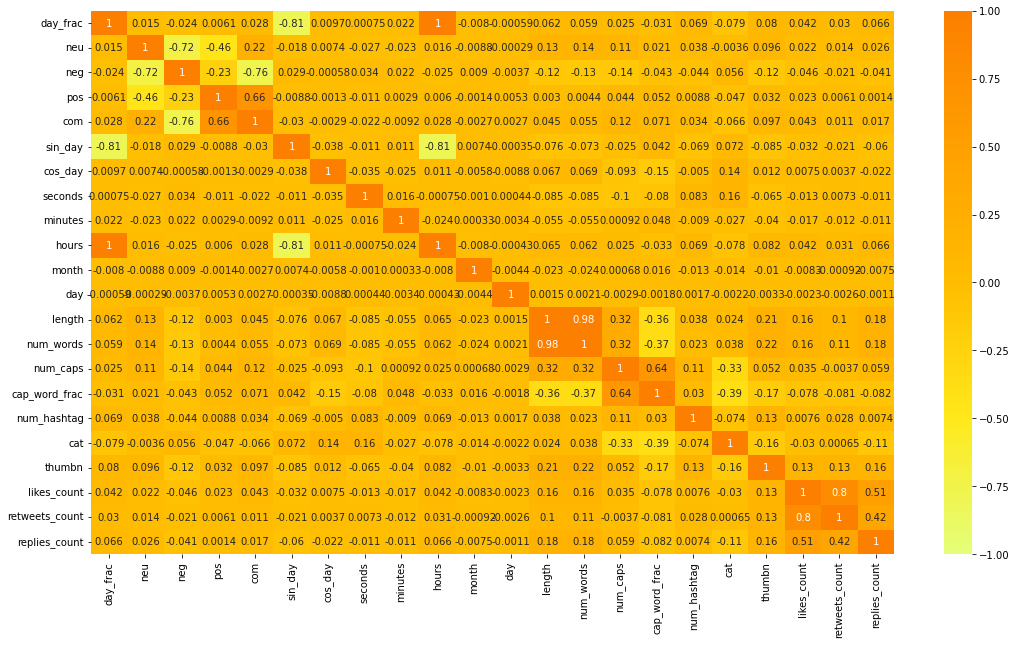

In [12]:
import seaborn as sb
plt.figure(figsize = (18,10))
corr = data_corr.corr()
sb.heatmap(corr, cmap = 'Wistia', vmin=-1, vmax=1,annot= True)
plt.show(sb)

## Split and Scale Data

In [13]:

del new_data["cleaned_tweet"]
X_train, X_test, y_train, y_test = train_test_split(new_data, data["viral"], test_size=0.2, random_state=42)


In [14]:
rc = RobustScaler()
X_train = rc.fit_transform(X_train.astype(np.float))
X_test= rc.transform(X_test.astype(np.float))

/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_48206/2028186727.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = rc.fit_transform(X_train.astype(np.float))
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_48206/2028186727.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= rc.transform(X_test.ast

## Linear, RandomForest and Multi-layer Perceptron Regressions

The RandomForest regression seems to have them best fit.

In [15]:

lr = LinearRegression().fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

#print score
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print('lr train score %.3f, lr test score: %.3f' % (
lr.score(X_train,y_train),
lr.score(X_test, y_test)))


lr.coef_: [ 6.33830693e-01  2.79131542e-01  1.26173906e-01  1.80192725e-01
 -1.48340352e-01  2.01991277e-01  5.00432503e-01  1.47911505e+00
  1.88103435e-01 -2.86519467e-01  8.98692625e-02  1.24838154e-01
  3.15825700e-01  1.13104422e-01  7.84216221e-02 -7.86966178e-01
  5.86935072e-02 -6.32857815e-02  2.97642008e-01 -2.11396346e-01
  2.65885539e-01 -1.42093102e-02  1.27279250e-01  4.11856738e-01
  1.10104494e-01 -2.35742101e-01 -3.72748214e-01  4.55936126e-01
 -5.75507665e-02 -4.86051071e-02  1.89697133e+00 -1.58639065e-01
  1.19212331e+00 -2.68388900e-01  2.53389174e-01  5.36587534e-01
 -3.91505174e-01 -1.17760655e-01  3.25906151e-01 -8.23818084e-02
  1.43235357e-01 -1.17038156e-01  2.46133325e-01  1.31741397e+00
 -1.25314066e-02  4.69683457e-01  2.25727758e-01  8.50802883e-02
 -9.58663052e-03  2.35670107e-01 -1.00591404e+12 -7.32858770e-01
 -5.47146918e-01 -3.25302488e-01  7.06397550e-02 -1.76190605e-01
  1.56751781e-01  8.26195799e+08  4.95717479e+10  9.91434958e+11
 -1.60022711e-0

In [16]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=1000)

#fit model
regr.fit(X_train,y_train.values.ravel())
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

#print score
print('Multi-layer Perceptron train score %.3f, Multi-layer Perceptron test score: %.3f' % (
regr.score(X_train,y_train),
regr.score(X_test, y_test)))

Multi-layer Perceptron train score 0.800, Multi-layer Perceptron test score: 0.768


In [17]:

forest = RFR(n_estimators=1000,
                     max_depth=20,
                     min_samples_split=2,
                     min_samples_leaf= 1,
                     bootstrap=True,
                     oob_score=False)

#fit model
forest.fit(X_train,y_train.values.ravel())
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

#print score
print('forest train score %.3f, forest test score: %.3f' % (
forest.score(X_train,y_train),
forest.score(X_test, y_test)))


forest train score 0.918, forest test score: 0.805


### Feature Importances

In [18]:
importance = pd.DataFrame({"Importance":forest.feature_importances_, "name": list(new_data.columns)}).sort_values("Importance", ascending=False)
importance

,Importance,name
68,0.306362,thumbn
65,0.193790,cap_word_frac
62,0.171070,length
67,0.098666,cat
57,0.027656,seconds
...,...,...
11,0.000217,death_vocab
26,0.000216,officials_vocab
41,0.000214,think_vocab
39,0.000191,south_vocab


### Random Forest Grid Search

In [19]:
from sklearn.model_selection import GridSearchCV
#Function to print best hyperparamaters: 
def print_best_params(gd_model):
    param_dict = gd_model.best_estimator_.get_params()
    model_str = str(gd_model.estimator).split('(')[0]
    print("\n*** {} Best Parameters ***".format(model_str))
    for k in param_dict:
        print("{}: {}".format(k, param_dict[k]))
    print()



###Random Forest parameter grid###
param_grid_rf = dict(n_estimators=[100, 1000],
                     max_depth=[2, 20, 40],
                     min_samples_split=[2],
                     min_samples_leaf= np.arange(1, 30, 10, int),
                     bootstrap=[True, False],
                     oob_score=[False, ])


forest = GridSearchCV(RFR(random_state=0), param_grid=param_grid_rf, cv=2, verbose=3)

#fit model
forest.fit(X_train,y_train.values.ravel())


#print score
print('\n\nforest train score %.3f, forest test score: %.3f' % (
forest.score(X_train,y_train),
forest.score(X_test, y_test)))

print_best_params(forest)


Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.440 total time=  36.6s
[CV 2/2] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.480 total time=  36.7s
[CV 1/2] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.444 total time= 6.1min
[CV 2/2] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.485 total time= 6.1min
[CV 1/2] END bootstrap=True, max_depth=2, min_samples_leaf=11, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.440 total time=  36.4s
[CV 2/2] END bootstrap=True, max_depth=2, min_samples_leaf=11, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.480 total time=  36.4s
[CV 1/2] END bootstrap=True, max_de

[CV 1/2] END bootstrap=False, max_depth=20, min_samples_leaf=11, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.709 total time=44.5min
[CV 2/2] END bootstrap=False, max_depth=20, min_samples_leaf=11, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.714 total time=43.0min
[CV 1/2] END bootstrap=False, max_depth=20, min_samples_leaf=21, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.731 total time= 4.3min
[CV 2/2] END bootstrap=False, max_depth=20, min_samples_leaf=21, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.730 total time= 4.0min
[CV 1/2] END bootstrap=False, max_depth=20, min_samples_leaf=21, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.731 total time=43.1min
[CV 2/2] END bootstrap=False, max_depth=20, min_samples_leaf=21, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.730 total time=40.5min
[CV 1/2] END bootstrap=False, max_depth=40, min_samples_leaf=1, min_samples_sp